In [1]:
from pathlib import Path
from rdkit import Chem
from iotbx.data_manager import DataManager
import numpy as np
import sys
import tqdm
from multiprocessing import Pool
from contextlib import closing
sys.path.append("..")

from phenixml.fragmentation.fragments import MolContainer, Fragment
from phenixml.fragmentation.fragmenters import MoleculeFragmenter, BondFragmenter, AngleFragmenter
from phenixml.featurizers.fragments.fingerprints import MorganFeaturizer, RDKFingerprint
from phenixml.labelers.fragment_labelers import BondFragmentLabeler, AngleFragmentLabeler
from phenixml.featurizers.fragments.ani_featurizer import ANIFeaturizer

from phenixml.fragments.nn_fragments import FragmentKNN
from phenixml.fragmentation.display import FragmentDisplay
display = FragmentDisplay()

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# get molecules
mol_dir = "/dev/shm/cschlick/geostd_passed/"
containers = MolContainer.from_folder(mol_dir,max_files=None)

In [3]:
%%time
# Fragment and featurize

def worker(container):
  fragmenter = BondFragmenter(exclude_elements=["H"])
  fragments = fragmenter(container)
  try:
    features = ANIFeaturizer.from_fragments_midpoint(fragments)
    return (fragments,features)
  except:
    return None

work = containers
results = []
with closing(Pool(processes=64)) as pool:
  for result in tqdm.tqdm(pool.imap_unordered(worker, work), total=len(work)):
      results.append(result)
  pool.terminate()

  
fragments = []
features = []
for result in results:
  if result is not None:
    fragments+= result[0]
    features.append(result[1])
features = np.vstack(features)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16150/16150 [00:50<00:00, 318.46it/s]


CPU times: user 46 s, sys: 14.1 s, total: 1min
Wall time: 53.8 s


In [4]:
%%time
# label the fragments
labeler = BondFragmentLabeler()
labels = labeler(fragments)

CPU times: user 14.5 s, sys: 114 ms, total: 14.6 s
Wall time: 14.6 s


In [5]:
# train/test split
from sklearn.model_selection import train_test_split
inds = np.arange(len(fragments))
train,test = train_test_split(inds,test_size=0.2)
feat_train, feat_test = features[train], features[test]
labels_train, labels_test = labels[train], labels[test]
frags_train = [fragments[i] for i in train]
frags_test = [fragments[i] for i in test]

# set up batches
n_batches = 4
batches = np.array_split(np.arange(len(train)),n_batches)
train_batches_feat = [feat_train[batch] for batch in batches]
train_batches_labels = [labels_train[batch] for batch in batches]
batches = list(zip(train_batches_feat,train_batches_labels))

## kNN

In [8]:
%%time
# Build the pynndescent index
knn = FragmentKNN(frags_train,feat_train)

CPU times: user 46min 52s, sys: 2min 33s, total: 49min 25s
Wall time: 3min 13s


In [23]:
# choose a single query to illustrate kNN search
query_idx = 126
query_frag = frags_test[query_idx]
query_feature = feat_test[query_idx]
query_label = labels_test[query_idx]

nbrs,inds = knn.query(query_feature,k=20, return_ind=True)
nbr_labels = labels_train[inds]

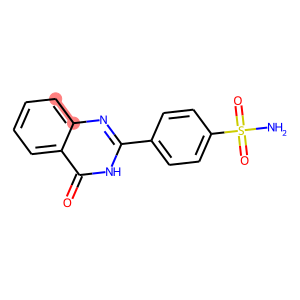

In [26]:
display(query_frag,hideHs=True,size=(300,300))

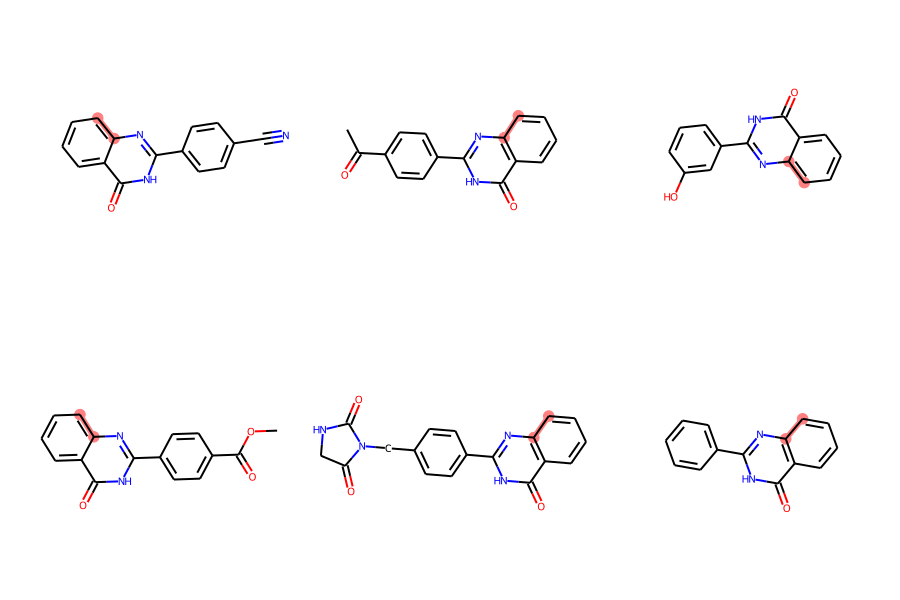

In [25]:
display(nbrs)

In [16]:
# kNN Regression
# Query the knn for the whole test set
nbrs,inds = knn.query(feat_test,k=20, return_ind=True)
nbr_labels = labels_train[inds]

In [21]:
nbr_mean_label = nbr_labels.mean(axis=1)[:,0]

In [22]:
from phenixml.visualization.plotting import plot_geom_eval

In [25]:
labels_test = labels_test[:,0]

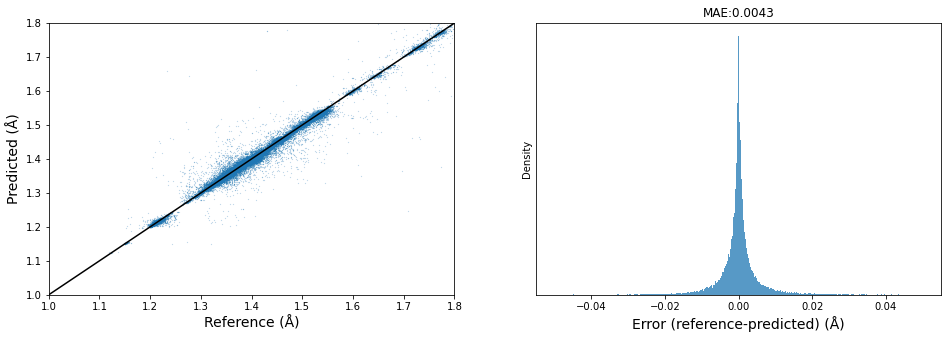

In [43]:
plot_geom_eval(labels_test,nbr_mean_label,mode="bond")

## MLP Regression

In [6]:
import torch
from phenixml.models.feature_regression import FeatureModel

In [25]:
# set up model
model = FeatureModel(feat_train.shape[1],256,1,n_hid_layers=2)
opt = torch.optim.Adam(model.parameters(),lr=1e-4)
metric = torch.nn.MSELoss()


# set up batches as pytorch tensors
batches = [(torch.tensor(feats,dtype=torch.get_default_dtype()),
            torch.tensor(labels,dtype=torch.get_default_dtype()))
            for feats,labels in batches]

In [29]:
# set up model
if gpu:
  model = model.to("cuda:0")

# train model
n_epoch=2000
epoch_losses = []

for epoch in tqdm.tqdm(range(n_epoch)):
  batch_losses = []
  for feats,labels in batches:
    if gpu:
      feats = feats.to("cuda:0")
      labels = labels.to("cuda:0")
    pred = model(feats)
    loss = metric(pred,labels)
    opt.zero_grad()
    loss.backward()
    opt.step()

    batch_losses.append(loss.item())
  epoch_losses.append(np.mean(epoch_losses))
  

  0%|                                                                                                                                                                                        | 0/2000 [00:00<?, ?it/s]/net/cci/cschlick/miniconda3/envs/restraintsML/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/net/cci/cschlick/miniconda3/envs/restraintsML/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [12:20<00:00,  2.70it/s]


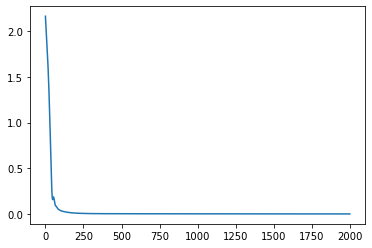

In [106]:
def to_np(tensor):
  return tensor.detach().cpu().numpy()

plt.plot(epoch_losses)

In [107]:
model = model.to("cpu")
pred = model(feat_test_t)

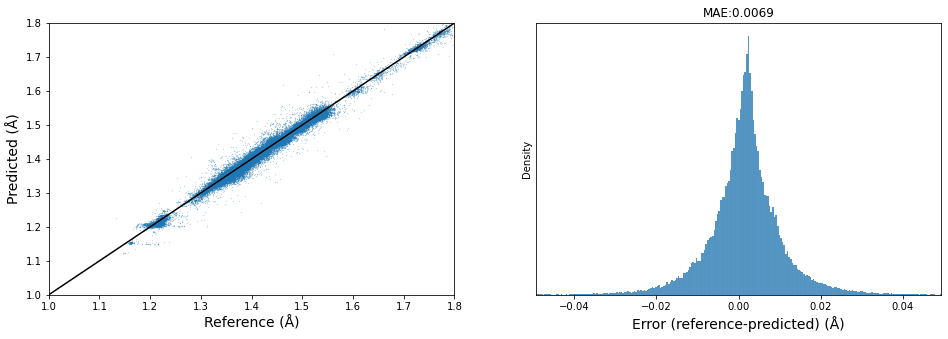

In [108]:
plot_geom_eval(labels_test,to_np(pred),mode="bond")

In [111]:
# import pickle
# with open("../tmp/knn.index.pkl","wb") as fh:
#   pickle.dump(knn.index,fh)
  
# knn index was 3.3 GB